In [1]:
import numpy as np
import pickle, gzip
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import time

def show(image):
    plt.figure(figsize=(10,10))
    new = image.copy()
    if image.shape == 3:                    # Switch R and B channels so it shows up as correctly as R,G,B, if image is 3-channel
        new[:,:,0] = image[:,:,2]
        new[:,:,2] = image[:,:,0]
    plt.imshow(new, cmap = "gray")

# Set seed for reproducibility
np.random.seed(0)

### Load data

In [2]:
# Load MNIST data

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_data, val_data, test_data = pickle.load(f, encoding="latin1")
    # train_data: tuple of (x_train, y_train), where x_train.shape = (50000, 784) and y_train.shape = (50000, 1)
    # val_data: tuple of (x_val, y_val), where x_val.shape = (10000, 784) and y_val.shape = (10000, 1)
    # test_data: tuple of (x_test, y_test), where x_test.shape = (10000, 784) and y_test.shape = (10000, 1)

x_train, y_train = train_data
x_val, y_val = val_data
x_test, y_test = test_data

# Combine training and validation data
x_train = np.concatenate((x_train, x_val), axis=0)
y_train = np.concatenate((y_train, y_val), axis=0)

# Reshape x
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# One-hot encode labels
y_train = np.eye(10)[y_train].reshape((-1, 10, 1))
y_test = np.eye(10)[y_test].reshape((-1, 10, 1))

# Zip data and labels into tuples
train_data = list(zip(x_train, y_train))
test_data = list(zip(x_test, y_test))

# Shuffle training data
np.random.shuffle(train_data)

### Model constructor

In [3]:
# Constructor for neural network
# Adapted from Nielsen textbook http://neuralnetworksanddeeplearning.com/chap1.html

class Model(object):

    # Fully connected neural network with layer i having sizes[i] neurons
    def __init__(self, sizes, weights=None, biases=None):
        self.num_layers = len(sizes)
        self.sizes = sizes

        # Initialize weights & biases if not provided
        if weights is None:
            self.weights = [np.random.randn(y, x) for y, x in zip(sizes[1:], sizes[:-1])] # Initialize weights array of shape (num_neurons_i, num_neurons_i-1) for each layer i except the input layer
        else:
            self.weights = weights
        
        if biases is None:
            self.biases = [np.random.randn(y, 1) for y in sizes[1:]] # Initialize biases array of shape (num_neurons_i, 1) for each layer i except the input layer
        else:
            self.biases = biases

        # Initialize training history
        self.history = {'train': {'acc':[], 'loss':[]}, 'val': {'acc':[], 'loss':[]}, 'latent':[]}

        # Number of parameters
        print(f'Number of model parameters: {sum(np.prod(w.shape) for w in self.weights) + sum(np.prod(b.shape) for b in self.biases)}')

    # Activation functions
    def activation(self, x):
        # x is a vector of length num_hidden_neurons generated by hidden layer affine transformation
        def sigmoid(x):
            # Overflow-safe sigmoid function (https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/)
            if x > 0:
                return 1 / (1 + np.exp(-x))
            else:
                return np.exp(x) / (1 + np.exp(x))
        return np.array(list(map(sigmoid, x)))

    # Derivative of activation function
    def activation_der(self, x):
        return self.activation(x) * (1 - self.activation(x))

    # # Softmax function
    # # Overflow-safe softmax function (https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/)
    # def softmax(self, x):
    #     # x is unnormalized vector of length output_size generated by output layer affine transformation
    #     return np.exp(x - x.max()) / np.sum(np.exp(x - x.max()), axis=0)

    # Loss function
    def loss(self, y_true, y_pred):
        return np.mean(((y_true - y_pred)**2)) # mean squared error

    # Derivative of loss function
    def loss_der(self, y_true, y_pred):
        return 2*(y_pred - y_true)

    # Backpropagation
    # Input x,y is single training example
    # Returns (nabla_b, nabla_w), where nabla_b is list of gradients of cost with respect to biases (one for each layer) and nabla_w is list of gradients of cost with respect to weights (one for each layer)
    def backprop(self, x, y):
        # Initialize lists of gradients for each layer
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        ###### Forward pass, storing weighted inputs (z) and activations for each layer ######
        activation = x # Initialize activation with input
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the weighted input z vectors, layer by layer
        # Iterate through each layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b # Compute weighted input z
            zs.append(z) # Store weighted input z
            activation = self.activation(z) # Compute activation
            activations.append(activation) # Store activation

        ###### Backward pass, computing gradients of cost with respect to biases and weights ######
        # Get gradients for output layer
        delta = self.loss_der(y, activations[-1]) * self.activation_der(zs[-1]) # Hadamard product of loss gradient and activation derivative for output layer
        nabla_b[-1] = delta # Store gradient of cost with respect to biases of last layer
        nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # Store gradient of cost with respect to weights of last layer
        # Iterate through each layer in reverse order, starting from second to last layer
        for l in range(2, self.num_layers):
            z = zs[-l] # Retrieve weighted input z for current layer
            delta = np.dot(self.weights[-l+1].transpose(), delta) * self.activation_der(z) # Compute gradient of cost with respect to weighted input z
            nabla_b[-l] = delta # Store gradient of cost with respect to biases of current layer
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose()) # Store gradient of cost with respect to weights of current layer

        # Get training performance
        acc = int(np.argmax(y) == np.argmax(activations[-1])) # Whether predicted label is equal to true label
        loss = self.loss(y, activations[-1]) # Compute loss

        return nabla_b, nabla_w, acc, loss

    # Model training using SGD
    # training_data is a list of tuples (x, y) representing the training inputs and the desired outputs
    def fit(self, training_data, epochs = 10, batch_size = 10, learning_rate = 1.5, validation_size=0.3, shuffle_order=None, store_latent_vecs=False, verbose=True):
        
        # Take last portion of training data as validation data
        training_data = training_data[:-int(validation_size*len(training_data))]
        val_data = training_data[-int(validation_size*len(training_data)):]

        ## Store baseline model characteristics (before training)
        # Evaluate model on validation data
        val_acc, val_loss = self.evaluate(val_data)
        print(f"Baseline characteristics: Validation accuracy: {val_acc:.4f}. Mean validation loss: {val_loss:.4f}")
        # Update global history
        self.history['train']['acc'].append(np.nan)
        self.history['train']['loss'].append(np.nan)
        self.history['val']['acc'].append(val_acc)
        self.history['val']['loss'].append(val_loss)
        # Store latent vectors
        if store_latent_vecs:
            self.history['latent'].append([(self.feedforward(x, layer_num = 2), np.argmax(y)) for x, y in training_data]) # Store latent representation of training data before training

        # Iterate through each epoch
        print(f'Training on {len(training_data)} examples, validating on {len(val_data)} examples')
        for j in range(epochs):
            # Initialize epoch training accuracy and loss history
            train_acc = []
            train_loss = []
            # Get time
            start_time = time.time()

            # Shuffle training data in preparation for SGD batching
            if shuffle_order is None:
                np.random.shuffle(training_data) # Shuffle training data randomly
            else:
                training_data = np.array(training_data, dtype=object)[shuffle_order[j]] # Shuffle training data according to order provided
            # Construct training batches for SGD
            batches = [training_data[k:k+batch_size] for k in range(0, len(training_data), batch_size)]
            # Iterate through all batches
            for batch in batches:
                nabla_b = [np.zeros(b.shape) for b in self.biases] # Initialize list of loss gradients with respect to biases, one gradient for each layer
                nabla_w = [np.zeros(w.shape) for w in self.weights] # Initialize list of loss gradients with respect to weights, one gradient for each layer
                # Iterate through all training examples in batch
                for x, y in batch:
                    delta_nabla_b, delta_nabla_w, acc, loss = self.backprop(x, y) # Compute loss gradients for each layer for single training example
                    nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)] # Accumulate bias loss gradients over batches for each layer
                    nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)] # Accumulate weight loss gradients over batches for each layer
                    # Update epoch training accuracy and loss history for single training example
                    train_acc.append(acc)
                    train_loss.append(loss)
                
                # Update weights and biases for each layer using average accumulated loss gradients
                self.weights = [w-(learning_rate/len(batch))*nw for w, nw in zip(self.weights, nabla_w)]
                self.biases = [b-(learning_rate/len(batch))*nb for b, nb in zip(self.biases, nabla_b)]
            
            # Compute epoch training accuracy and loss
            train_acc, train_loss = np.mean(train_acc), np.mean(train_loss)
            # Evaluate model on validation data
            val_acc, val_loss = self.evaluate(val_data)
            # Get time
            end_time = time.time()
            # Print epoch number (epochs start at 1)
            if verbose:
                print(f"Epoch {j+1} complete. Time taken: {end_time - start_time:.2f} seconds.")
                print(f"Training accuracy: {train_acc:.4f}. Validation accuracy: {val_acc:.4f}. Mean training loss: {train_loss:.4f}. Mean validation loss: {val_loss:.4f}")

            # Update global history
            self.history['train']['acc'].append(train_acc)
            self.history['train']['loss'].append(train_loss)
            self.history['val']['acc'].append(val_acc)
            self.history['val']['loss'].append(val_loss)
            # Store latent vectors
            if store_latent_vecs:
                self.history['latent'].append([(self.feedforward(x, layer_num = 2), np.argmax(y)) for x, y in training_data]) # Store latent representation of training data after each epoch


    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for (x, y) in test_data]
        acc = sum(int(y_pred == y_true) for (y_pred, y_true) in test_results)/len(test_results)
        loss = np.mean([self.loss(self.feedforward(x), y) for (x, y) in test_data])

        return acc, loss

    # Get feedforward activations for given layer (default is last layer)
    # Equivalent to Tensorflow get_layer()
    def feedforward(self, x, layer_num = None):
        # Dynamically update activations for each layer while moving forward through the network, starting with shape (input_size, 1) and ending with shape (output_size, 1)
        if layer_num is None:
            layer_num = self.num_layers - 1
        activations = x
        current_layer = 1
        while current_layer <= layer_num:
            activations = self.activation(np.dot(self.weights[current_layer - 1], activations) + self.biases[current_layer - 1])
            current_layer += 1
        return activations

### Set global stochastic params

In [4]:
# Model architecture
sizes = [784, 30, 2, 10]
epochs = 12
batch_size = 10
learning_rate = 1.5
validation_size=0.3

# Initialize weights array of shape (num_neurons_i, num_neurons_i-1) for each layer i except the input layer
weights = [np.random.randn(y, x) for y, x in zip(sizes[1:], sizes[:-1])]

# Initialize biases array of shape (num_neurons_i, 1) for each layer i except the input layer
biases = [np.random.randn(y, 1) for y in sizes[1:]] 

# Initialize list of data indices for data shuffling per epoch
shuffle_order = [np.random.permutation(int(len(train_data)*(1 - validation_size))) for i in range(epochs)]

### Hyperparameter optimization

In [5]:
# accuracies = []
# losses = []

# for learning_rate_o in [0.5, 1, 1.5, 2, 2.5, 3]:
#     model = Model(sizes, weights, biases)
#     model.fit(train_data, epochs = epochs, batch_size = batch_size, learning_rate = learning_rate_o, validation_size = validation_size, shuffle_order = shuffle_order, store_latent_vecs = True, verbose = False)
#     test_acc, test_loss = model.evaluate(test_data)
#     accuracies.append(test_acc)
#     losses.append(test_loss)

# print(f'Test accuracies: {accuracies}. Mean test losses: {losses}')

### Verify that model training is reproducible

In [6]:
# # Build & train first model
# model1 = Model(sizes, weights, biases)
# model1.fit(train_data, epochs = epochs, batch_size = batch_size, learning_rate = learning_rate, validation_size = validation_size, shuffle_order = shuffle_order, store_latent_vecs = False)
# test_acc, test_loss = model1.evaluate(test_data)
# print(f'Test accuracy: {test_acc}. Mean test loss: {test_loss}')

In [7]:
# # Build & train second model
# model2 = Model(sizes, weights, biases)
# model2.fit(train_data, epochs = epochs, batch_size = batch_size, learning_rate = learning_rate, validation_size = validation_size, shuffle_order = shuffle_order, store_latent_vecs = True)
# test_acc, test_loss = model2.evaluate(test_data)
# print(f'Test accuracy: {test_acc}. Mean test loss: {test_loss}')

In [8]:
# # Are model weights reproducible?
# print(f'Model weights were reproducible: {[np.array_equal(model1.weights[i], model2.weights[i]) for i in range(len(model1.weights))]}')

### Visualize latent space over epochs

In [9]:
# Build & train model
model = Model(sizes, weights, biases)
model.fit(train_data, epochs = 12, batch_size = batch_size, learning_rate = learning_rate, validation_size = validation_size, shuffle_order = shuffle_order, store_latent_vecs = True)
test_acc, test_loss = model.evaluate(test_data)
print(f'Test accuracy: {test_acc}. Mean test loss: {test_loss}')

Number of model parameters: 23642
Baseline characteristics: Validation accuracy: 0.0962. Mean validation loss: 0.3914
Training on 42000 examples, validating on 12600 examples
Epoch 1 complete. Time taken: 76.84 seconds.
Training accuracy: 0.4058. Validation accuracy: 0.5238. Mean training loss: 0.0697. Mean validation loss: 0.0620
Epoch 2 complete. Time taken: 77.51 seconds.
Training accuracy: 0.5539. Validation accuracy: 0.6137. Mean training loss: 0.0592. Mean validation loss: 0.0563
Epoch 3 complete. Time taken: 69.01 seconds.
Training accuracy: 0.6073. Validation accuracy: 0.6633. Mean training loss: 0.0549. Mean validation loss: 0.0516
Epoch 4 complete. Time taken: 72.17 seconds.
Training accuracy: 0.6270. Validation accuracy: 0.6349. Mean training loss: 0.0520. Mean validation loss: 0.0516
Epoch 5 complete. Time taken: 71.19 seconds.
Training accuracy: 0.6495. Validation accuracy: 0.6632. Mean training loss: 0.0505. Mean validation loss: 0.0522
Epoch 6 complete. Time taken: 71.00

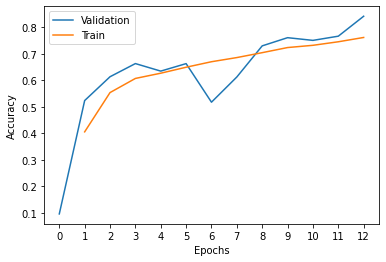

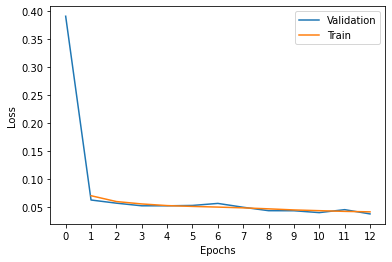

In [10]:
# Plot accuracy history
plt.plot(range(len(model.history['val']['acc'])), model.history['val']['acc'], label='Validation')
plt.plot(range(len(model.history['train']['acc'])), model.history['train']['acc'], label='Train')
plt.xticks(np.arange(0, len(model.history['val']['acc']), 1)) # Set xticks
plt.ylabel('Accuracy') # Y axis label
plt.xlabel('Epochs') # X axis label
plt.legend() # Add legend
plt.show();

# Plot loss history
plt.plot(range(len(model.history['val']['loss'])), model.history['val']['loss'], label='Validation')
plt.plot(range(len(model.history['train']['loss'])), model.history['train']['loss'], label='Train')
plt.xticks(np.arange(0, len(model.history['val']['loss']), 1)) # Set xticks
plt.ylabel('Loss') # Y axis label
plt.xlabel('Epochs') # X axis label
plt.legend() # Add legend
plt.show();

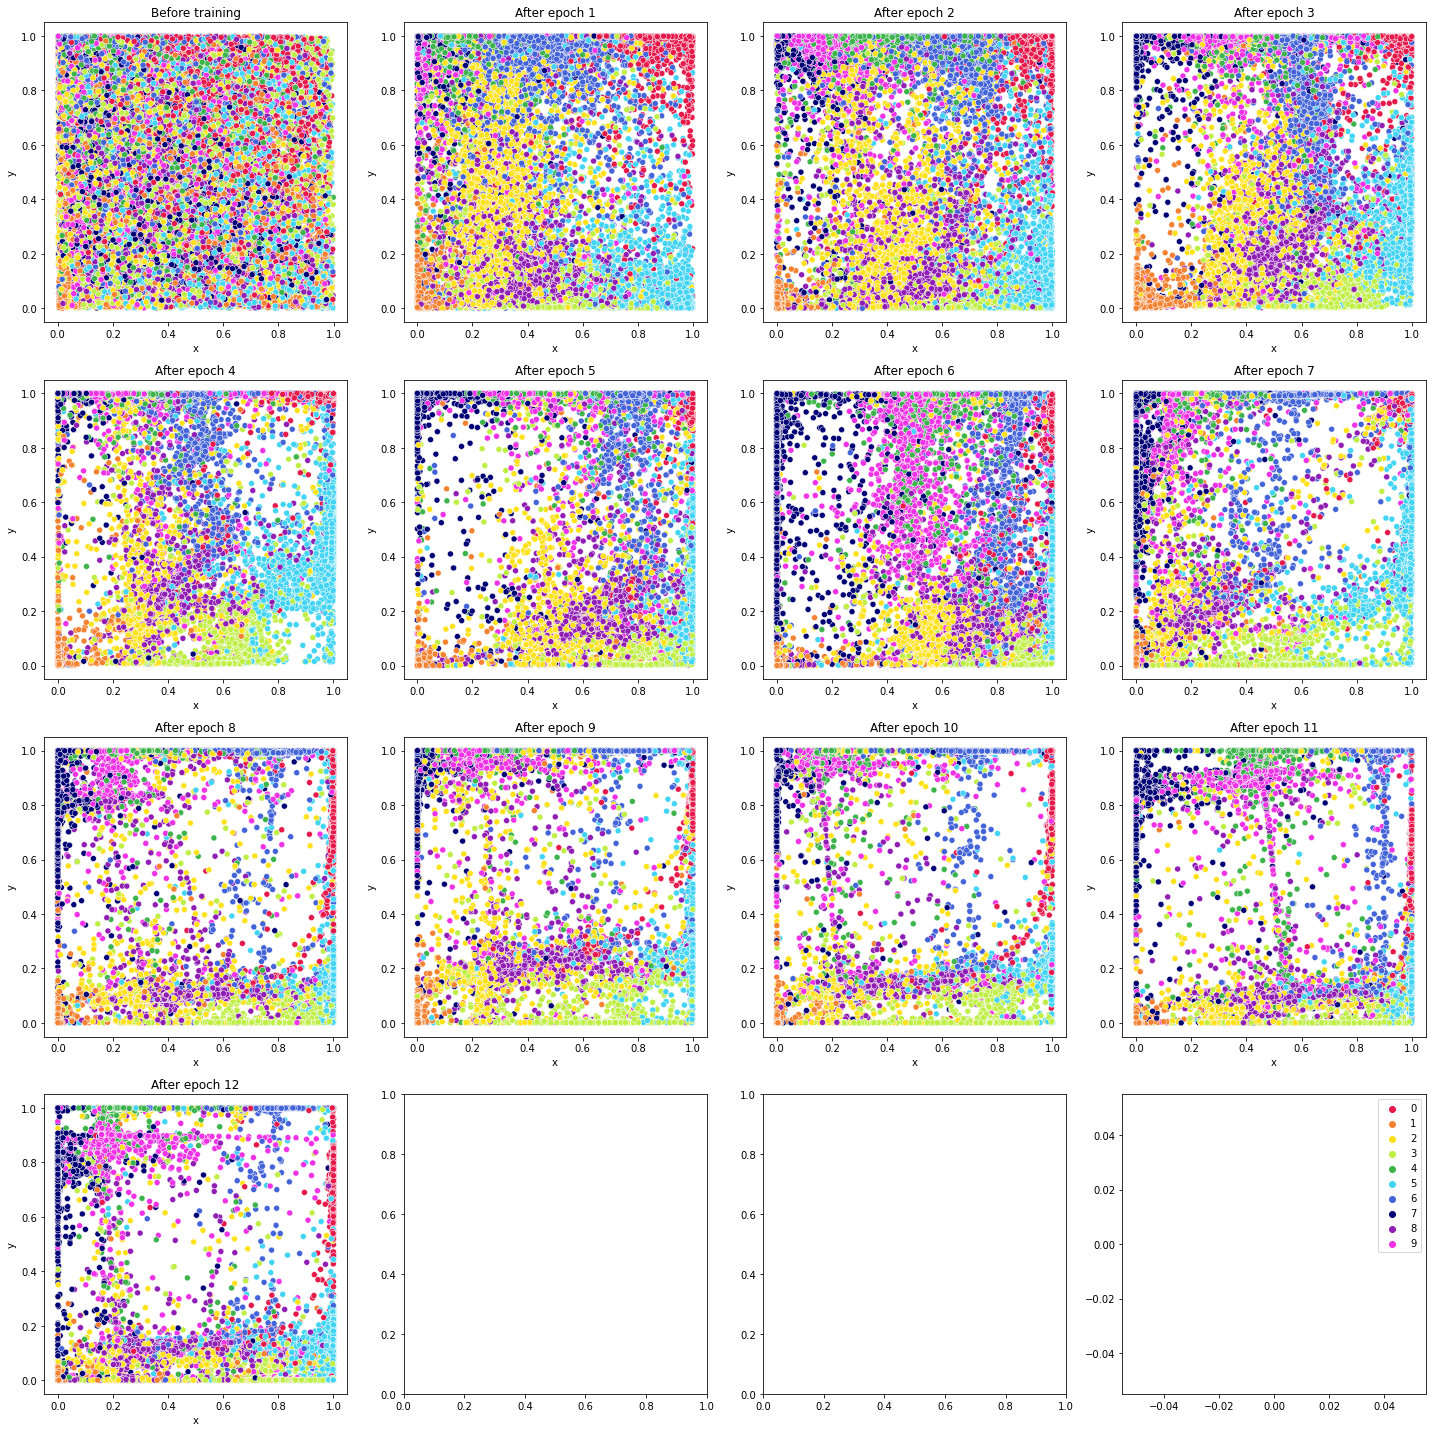

In [14]:
# Retrieve latent vectors from model history and plot them

nrows = int(np.ceil(np.sqrt(len(model.history['latent']))))
ncols = int(np.ceil(len(model.history['latent']) / nrows))
fig, ax = plt.subplots(nrows, ncols, tight_layout=True, figsize = (ncols * 5, nrows * 5))
ax = ax.flatten()

for epoch in range(0, len(model.history['latent'])):
    # Create dataframe
    df = []
    for index, element in enumerate(model.history['latent'][epoch]):
        vec, label = element
        df.append({'x': vec[0][0], 'y': vec[1][0], 'digit': label})
    df = pd.DataFrame(df)

    # Plot latent vectors in 2D, color-coded by digit
    # print(f'Plotting {len(df)} examples.')
    colors = sns.color_palette(['#e6194B','#f58231','#ffe119','#bfef45','#3cb44b','#42d4f4','#4363d8', '#000075', '#911eb4','#f032e6'])
    sns.scatterplot(data=df, x="x", y="y", hue="digit", palette=colors, ax=ax[epoch], legend=False)

    # Add title
    if epoch == 0:
        title = 'Before training'
    else:
        title = f'After epoch {epoch}'
    ax[epoch].set_title(title)

# Create legend for each digit
for i in range(10):
    ax[-1].scatter([], [], color=colors[i], label=i)
ax[-1].legend()

# Save plot to file
plt.savefig(f'results/latent_over_epochs.png')
plt.show();

In [17]:
# # Inspect last layer activations for training data
# last_layer = [model.feedforward(x, layer_num = 3) for x, y in train_data[:1]]
# print(last_layer[0].sum())
# print(last_layer[0])
# print(train_data[0][1])

### Quantify latent space similarity

In [16]:
# Function to get adjacency matrix for a given latent distribution
def get_adjacency_matrix(latent_distribution):
    # Create dataframe
    df = []
    for index, element in enumerate(latent_distribution):
        vec, label = element
        df.append({'x': vec[0][0], 'y': vec[1][0], 'digit': label})
    df = pd.DataFrame(df)

    # Get centroid coordinates
    centroids = df.groupby('digit').mean()

    # Create adjacency matrix
    adjacency_matrix = np.zeros((10, 10))
    for i in range(10):
        for j in range(10):
            if i == j:
                continue
            else:
                adjacency_matrix[i][j] = np.linalg.norm(centroids.iloc[i] - centroids.iloc[j]) # Euclidean distance (L2 norm)
    
    return adjacency_matrix

# Function to compute adjacency spectral distance
def adjacency_spectral_distance(adjacency_matrix_1, adjacency_matrix_2):
    # Compute spectral distance
    eigvals_1, eigvecs_1 = np.linalg.eig(adjacency_matrix_1)
    eigvals_2, eigvecs_2 = np.linalg.eig(adjacency_matrix_2)
    spectral_distance = np.linalg.norm(eigvals_1 - eigvals_2)

    return spectral_distance

In [ ]:
# Calculate adjacency spectral distance between latent distributions of consecutive epochs
spectral_distances = []
for i in range(len(model.history['latent']) - 1):
    adjacency_matrix_1 = get_adjacency_matrix(model.history['latent'][i])
    adjacency_matrix_2 = get_adjacency_matrix(model.history['latent'][i + 1])
    spectral_distances.append(adjacency_spectral_distance(adjacency_matrix_1, adjacency_matrix_2))

# Get change in training loss between consecutive epochs
loss_deltas = []
for i in range(len(model.history['train']['loss']) - 1):
    loss_deltas.append(model.history['train']['loss'][i + 1] - model.history['train']['loss'][i])

# Plot spectral distance vs. change in training loss
plt.plot(spectral_distances, loss_deltas)

In [ ]:
# Get Frobenius distance between bottleneck weight matrices of consecutive epochs
weight_distances = []
for i in range(len(model.history['bottleneck_weights']) - 1):
    weight_distances.append(np.linalg.norm(model.history['bottleneck_weights'][i + 1] - model.history['bottleneck_weights'][i]))

# Plot spectral distance vs. Frobenius weight distance
plt.plot(spectral_distances, weight_distances)